# Homework 7 (50 points)

In this Homework, we will try to classify observations of space to be either stars, galaxies or quasars based on the RD14 from the Sloan Digital Sky Survey  (SDSS). The Sloan Digital Sky Survey is a project which offers public data of space observations. Observations have been made since 1998 and have been made accessible to everyone who is interested. 

http://www.sdss.org/
![alt text](http://www.fingerprintdigitalmedia.com/wp-content/uploads/2014/08/sdss1.jpg)

For this purpose a special 2.5 m diameter telescope was built at the Apache Point Observatory in New Mexico, USA. The telescope uses a camera of 30 CCD-Chips with 2048x2048 image points each. The chips are ordered in 5 rows with 6 chips in each row. Each row observes the space through different optical filters (u, g, r, i, z) at wavelengths of approximately 354, 476, 628, 769, 925 nm.


In this homework we will train several classifier to predict the class of a celestial object based on the observations (features). We will practice data prep, dimensionality reduction, model design and training, model comparison, and feature importance selection.

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
import sklearn
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline


## 1) Data Preparation (20 points)

We follow the following steps:
* read (1 point)
* clean (3 points)
* correlate (4 points)
* explore, spread of values (3 points)
* dimensionality reduction (9 points)

### 1.1 Data read
Read the pandas fata frame from the csv file "Skyserver_SQL2_27_2018.csv" and skip the first row.

**Task: read (1 point)**

Save a copy of the data frame just in case.

In [2]:
Sky_df = pd.read_csv('Skyserver_SQL2_27_2018.csv')
Sky_dfcopy = Sky_df.copy(True)

**Description of the data fields**

* objid = Object Identifier, self explanatory.
* ra = J2000 Right Ascension (r-band). Angular that is measured eastward along the celestial equator from the Sun at the March equinox to the hour circle of the point above the earth in question.   https://en.wikipedia.org/wiki/Right_ascension
* dec = J2000 Declination (r-band). Angle that is measured north or south of the celestial equator, along the hour circle passing through the point in question. https://en.wikipedia.org/wiki/Declination



The Gunn astronomic magnitude system. u, g, r, i, z represent the response of the 5 bands of the telescope.

Further Information: http://astroweb.case.edu/ssm/ASTR620/mags.html 
* u = better of DeV/Exp magnitude fit
* g = better of DeV/Exp magnitude fit
* r = better of DeV/Exp magnitude fit
* i = better of DeV/Exp magnitude fit
* z = better of DeV/Exp magnitude fit




Run, rerun, camcol and field are features which describe a field within an image taken by the SDSS. A field is basically a part of the entire image corresponding to 2048 by 1489 pixels. 
* run = Run Number, which identifies the specific scan. 
* rereun = Rerun Number, which specifies how the image was processed.
* camcol = Camera column, a number from 1 to 6, identifying the scanline within the run.
* field = Field number, which typically starts at 11 (after an initial rampup time), and can be as large as 800 for particularly long runs.
* specobjid = Object Identifier
* class = object class (galaxy, star or quasar object): The class identifies an object to be either a galaxy, star or quasar. This will be the response variable which we will be trying to predict.

* redshift = Final Redshift: In physics, **redshift** happens when light or other electromagnetic radiation from an object is increased in wavelength, or shifted to the red end of the spectrum. 

* plate = plate number: Each spectroscopic exposure employs a large, thin, circular metal **plate** that positions optical fibers via holes drilled at the locations of the images in the telescope focal plane. These fibers then feed into the spectrographs. Each plate has a unique serial number, which is called plate in views such as SpecObj in the CAS.

* mjd = MJD of observation, **Modified Julian Date**, used to indicate the date that a given piece of SDSS data (image or spectrum) was taken.
* fiberid = fiber ID. The SDSS spectrograph uses optical fibers to direct the light at the focal plane from individual objects to the slithead. Each object is assigned a corresponding **fiberID**. 

**Further information on SDSS images and their attributes:** 

http://www.sdss3.org/dr9/imaging/imaging_basics.php

http://www.sdss3.org/dr8/glossary.php

### 1.2 Data Cleaning 

Basic stats about our dataset. 

**Task: Provide basic infor for the pandas dataframe head (0.5 point)**

In [3]:
Sky_df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


**Task: Find the data types of the database (floats, string, etc etc) using the ``info()`` function (0.5 point).**

In [4]:
Sky_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      10000 non-null  float64
 1   ra         10000 non-null  float64
 2   dec        10000 non-null  float64
 3   u          10000 non-null  float64
 4   g          10000 non-null  float64
 5   r          10000 non-null  float64
 6   i          10000 non-null  float64
 7   z          10000 non-null  float64
 8   run        10000 non-null  int64  
 9   rerun      10000 non-null  int64  
 10  camcol     10000 non-null  int64  
 11  field      10000 non-null  int64  
 12  specobjid  10000 non-null  float64
 13  class      10000 non-null  object 
 14  redshift   10000 non-null  float64
 15  plate      10000 non-null  int64  
 16  mjd        10000 non-null  int64  
 17  fiberid    10000 non-null  int64  
dtypes: float64(10), int64(7), object(1)
memory usage: 1.4+ MB


Are there any obvious feature (or element of the dataframe) that should not impact our prediction?
 
**objid** and **specobjid** are just identifiers for accessing the rows back when they were stored in the original databank. Therefore we will not need them for classification as they are not related to the outcome.
The features **run**, **rerun**, **camcol** and **field** are values which describe parts of the camera at the moment when making the observation, e.g. 'run' represents the corresponding scan which captured the oject.

Source: http://www.sdss3.org/dr9/imaging/imaging_basics.php

**Task: Drop these columns in the pandas dataframe. (1 point)**

In [5]:
Sky_df = Sky_df.drop(columns = ["objid", "specobjid", 'run', 'rerun', 'camcol', 'field', 'plate', 'mjd', 'fiberid'])

Find our how many examples there are, how many attributes or feature, and the type of class.

In [6]:
print(Sky_df.count())
print("Number of attributes: " + str(len(Sky_df.columns)))
print("Type of classes " + str(Sky_df['class'].unique()))

ra          10000
dec         10000
u           10000
g           10000
r           10000
i           10000
z           10000
class       10000
redshift    10000
dtype: int64
Number of attributes: 9
Type of classes ['STAR' 'GALAXY' 'QSO']


**Task: How many objects are in each class? (1 point)**

In [7]:
# Count the elements in each class
Sky_df['class'].value_counts()

GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64

The classes are "GALAXY", "STAR", and "QSO" (quasars). They are defined as strings, but we will convert them to integer in order to apply a loss function on the class labels during training. For this, we use the ``sklearn.preprocessing.LabelEncoder()`` function. We will do so and modify the classes in the dataframe. We should keep a copy of the original data frame to be safe.

In [8]:
Sky_df_save = Sky_df.copy(True)  # make a copy of the original data before cleaning it. That works well when the data is small.

# encode class labels to integers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(Sky_df['class'])
Sky_df['class'] = y_encoded
#  GALAXY = 0
# STAR = 2
# QSO = 1
Sky_df.head()

,ra,dec,u,g,r,i,z,class,redshift
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,2,-0.000009
1,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,2,-0.000055
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,0,0.123111
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,2,-0.000111
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,2,0.000590


### 1.3 Data correlations
Now let's find the most basic correlations among features. This can be done using the ``corr()`` function to apply on the pandas dataframe. Evaluate this function and comment on what feature is correlated among others. It is convenient to use the matplotlib function ``matshow()`` for clarity. ``seaborn`` is a python module that makes really pretty statistical plots https://seaborn.pydata.org/index.html#. Install it with ``pip`` and import it.

In [9]:
!pip install seaborn
import seaborn as sns

  Using cached seaborn-0.11.1-py3-none-any.whl (285 kB)


**Task: Plot the correlation matrix that can be called in the pandas dataframe. (2 points)**

Hints:

Use functions of ``heatmap``, add the labels in the axes. The colormap ``coolwarm`` is nice for divergent scales like correlations that vary between -1 and 1. The argument ``center=0`` ensures that the colormap is divergent from zero. Make sure to ignore the label column "class". Remember that dropping a column can be done in place ``sdss_df.drop('class', axis=1)``.

<AxesSubplot:>

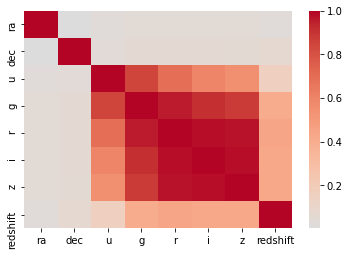

In [10]:
# answer
corr_matrix = Sky_df.drop('class', axis = 1).corr()
sns.heatmap(corr_matrix, cmap = 'coolwarm', center = 0 )

**Task: Reproduce the same plot for each of the three classes. (1 point)**
You can select the values from the pandas dataframe by selecting over the column 'class'. 

Text(0.5, 1.0, 'Quasars')

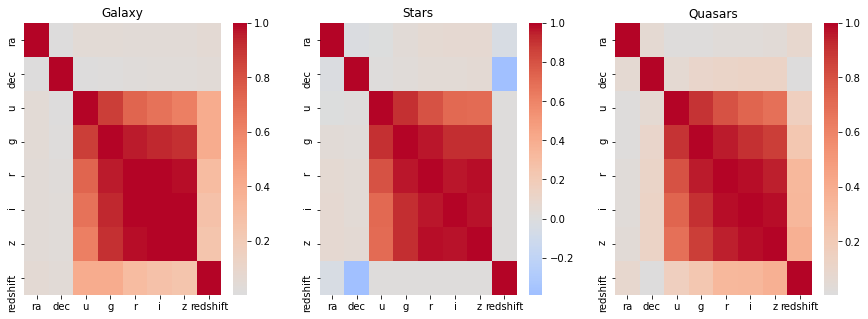

In [11]:
# make the same plot for Galaxies
# "GALAXY" is label 0
galaxy_corr = Sky_df[Sky_df['class'] == 0].drop('class', axis = 1).corr()
#sns.heatmap(galaxy_corr, cmap = 'coolwarm', center = 0)

# Make the same plot for Stars (label 2)
star_corr = Sky_df[Sky_df['class'] == 2].drop('class', axis = 1).corr()
#sns.heatmap(star_corr, cmap = 'coolwarm', center = 0)

# make the same plots for quasars (label 1)
qso_corr = Sky_df[Sky_df['class'] == 1].drop('class', axis = 1).corr()
#sns.heatmap(qso_corr, cmap = 'coolwarm', center = 0)

fig, axes = plt.subplots(1,3, figsize = (15,5))
sns.heatmap(galaxy_corr, cmap = 'coolwarm', center = 0, ax = axes[0])
axes[0].set_title("Galaxy")
sns.heatmap(star_corr, cmap = 'coolwarm', center = 0, ax = axes[1])
axes[1].set_title("Stars")
sns.heatmap(qso_corr, cmap = 'coolwarm', center = 0, ax = axes[2])
axes[2].set_title("Quasars")

**Task: Can you comment on groups of observations that can be grouped together or that appear independent from each other given these correlations, and if there is any difference between the three celestial objects? (**1 point**)**

There appears to be correlations between u, g, r, i, and z in all of the celestial classes. There is slightly more correlation bwtween those attributes and redshift in Galaxy and Quasars than Stars. And the ra, and dec attrributes appear independent.

### 1.5 Data exploration
Given the structure of the correlations, we will explore the values of the data.

#### 1.5.a. Distributions of redshift
"redshifting" happens when the source of light is becoming more distant to the receiver: the object is moving away from Earth. 

**Task: plot histograms for the 'redshift' feature column for each class (1 point).**

Text(0.5, 1.0, 'Quasars')

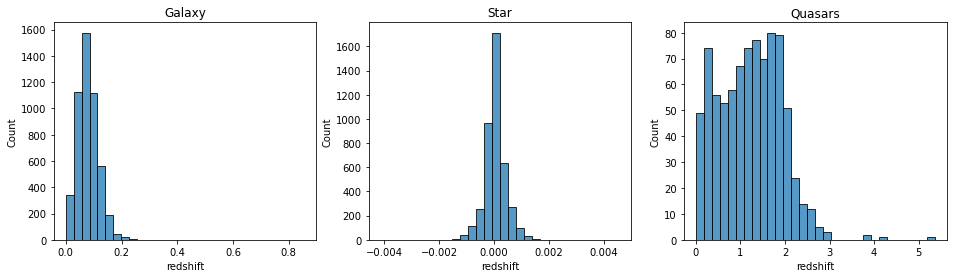

In [12]:
# answer
galaxy = Sky_df[Sky_df['class'] == 0]
star = Sky_df[Sky_df['class'] == 2]
qso = Sky_df[Sky_df['class'] == 1]

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
sns.histplot(galaxy['redshift'], bins = 30, ax = axes[0])
axes[0].set_title("Galaxy")
sns.histplot(star['redshift'], bins = 30, ax = axes[1])
axes[1].set_title("Star")
sns.histplot(qso['redshift'], bins = 30, ax = axes[2])
axes[2].set_title("Quasars")

**Task : Describe briefly the difference between the three histograms. (0.5 point)**

<!-- # answer -->
* **Star:** The histogram looks like a truncated zero-centered normal distribution. It looks like stars are both coming toward and away from the Earth.

* **Galaxy:** The redshift values may come from a slightly right-shifted normal distribution which is centered around 0.075. It looks like galaxies are moving away from the Earth but at slow speeds.

* **QSO:** The redshift values for QSOs are a lot more uniformly distributed than for Stars or Galaxies. They are roughly evenly distributed from 0 to 3, than the occurences decrease drastically. For 4 oder ~5.5 there are some outliers. This probably means that quasards are moving away from the earth with a diverse range of speeds.


#### 1.5.b. Right ascension (ra) and declination (dec) 

We will now plot the right ascension versus the declination depending on the class. You can use the ``lmplot`` function in ``seaborn`` (https://seaborn.pydata.org/generated/seaborn.lmplot.html) to represent the sky view of these objects.

/srv/conda/envs/notebook/lib/python3.9/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Equatorial coordinates')

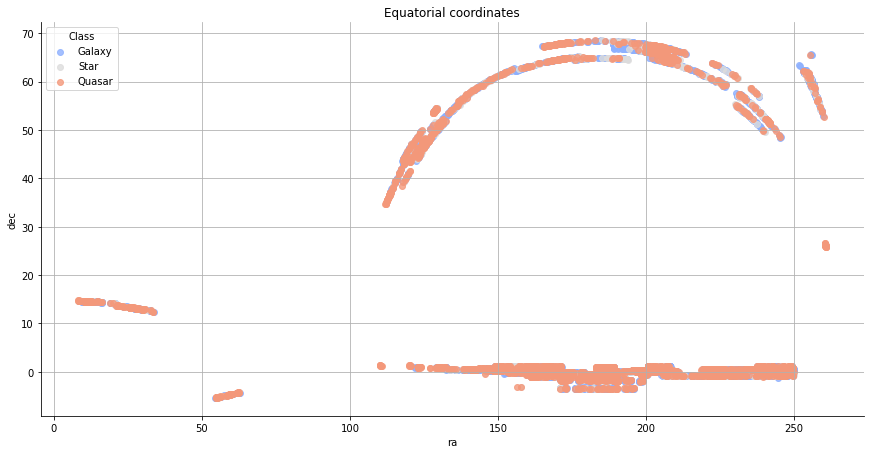

In [13]:
sns.lmplot(x='ra', y='dec', data=Sky_df, hue='class', fit_reg=False, palette='coolwarm', size=6, aspect=2,legend=False)
plt.legend(title='Class', loc='upper left', labels=['Galaxy', 'Star','Quasar'])
plt.grid(True)
plt.title('Equatorial coordinates')

**Task: do you see any obvious differences such that one could easily discriminate between the two coordinates? (0.5 point)**

There does not appear to be any obvious differences bewteen the classes and the coordinates

#### 1.5.c Filters - u,g,r,i,z 

Recall: u, g, r, i, z represent the different wavelengths which are used to capture the observations. According to the correlation matrix, they are correlated for all three classes.

Therefore it is interesting to see that band 'u' is less correlated to the other bands. 

**Task Plot histograms and discuss why you expect these features to be correlated (1 points)**

<AxesSubplot:xlabel='z', ylabel='Count'>

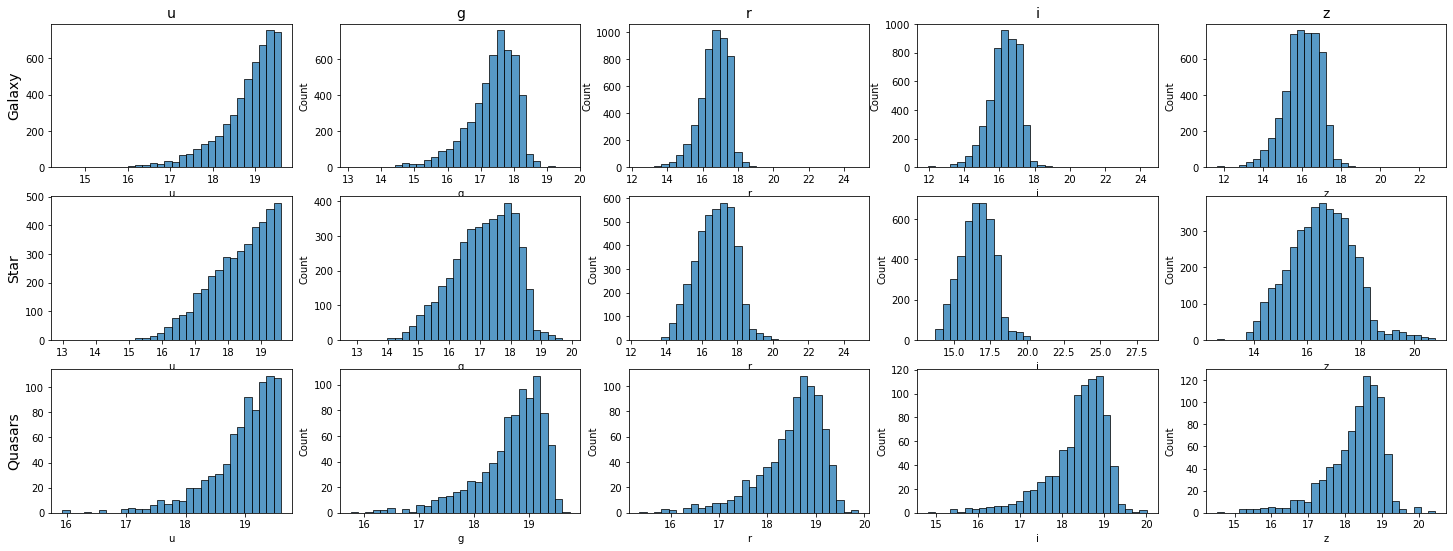

In [14]:
# Plot of histograms
import warnings
warnings.filterwarnings('ignore')

galaxy = Sky_df[Sky_df['class'] == 0]
star = Sky_df[Sky_df['class'] == 2]
qso = Sky_df[Sky_df['class'] == 1]

fig, axes = plt.subplots(nrows=3, ncols=5,figsize=(25, 9))
axes[0,0].set_title('u', fontsize = 14)
axes[0,1].set_title('g', fontsize = 14)
axes[0,2].set_title('r', fontsize = 14)
axes[0,3].set_title('i', fontsize = 14)
axes[0,4].set_title('z', fontsize = 14)

axes[0,0].set_ylabel("Galaxy", fontsize = 14)
axes[1,0].set_ylabel("Star", fontsize = 14)
axes[2,0].set_ylabel("Quasars", fontsize = 14)

sns.histplot(galaxy['u'], bins = 30, ax = axes[0,0])
sns.histplot(galaxy['g'], bins = 30, ax = axes[0,1])
sns.histplot(galaxy['r'], bins = 30, ax = axes[0,2])
sns.histplot(galaxy['i'], bins = 30, ax = axes[0,3])
sns.histplot(galaxy['z'], bins = 30, ax = axes[0,4])


sns.histplot(star['u'], bins = 30, ax = axes[1,0])
sns.histplot(star['g'], bins = 30, ax = axes[1,1])
sns.histplot(star['r'], bins = 30, ax = axes[1,2])
sns.histplot(star['i'], bins = 30, ax = axes[1,3])
sns.histplot(star['z'], bins = 30, ax = axes[1,4])

sns.histplot(qso['u'], bins = 30, ax = axes[2,0])
sns.histplot(qso['g'], bins = 30, ax = axes[2,1])
sns.histplot(qso['r'], bins = 30, ax = axes[2,2])
sns.histplot(qso['i'], bins = 30, ax = axes[2,3])
sns.histplot(qso['z'], bins = 30, ax = axes[2,4])

The bands are well correlated, besides 'u', because they somewhat vary in value distribution for each class. 

<!-- Anwer: -->

### 1.6 Data Dimensionality Reduction
At this point, we are left with 8 features: redshift, u, g, r, i, z, ra, and dec. Among these, the filters (u, g, r, i, z) are correlated to each other. There is therefore a potential for reducing the dimensions of the features using PCA on these 5 features.

We will use the skilearn function ``sklearn.decomposition.PCA()`` to fit and transform the data into the PC coordinates. Lets' first explore how many PCs we need. Fit the PCA function over the total number of filters. You will fit the PCA function over an array with the columns selected from the dataframe. 

**Task: Perform the PCA over a max number of PCs, output the explained variance ratio values, decide on an appropriate maximum number of PC to use (6 points)**

[4.93938302 0.47898392 0.02506316 0.02242287 0.00620751]


Text(0, 0.5, 'Explained Variance')

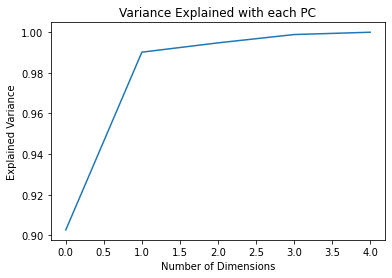

In [15]:
# answer
Sky_df_bands = Sky_df.drop(['class', 'redshift', 'ra','dec'], axis = 1)
from sklearn import decomposition

PCA = sklearn.decomposition.PCA(n_components = 5)
Sky_PCA = PCA.fit(Sky_df_bands)
print(Sky_PCA.explained_variance_)
plt.plot(np.cumsum(Sky_PCA.explained_variance_ratio_))
plt.title("Variance Explained with each PC")
plt.xlabel("Number of Dimensions")
plt.ylabel("Explained Variance")

From the variance plot, more than 95% of the variance is explained by the first PC. There is some increase from 1 to 2, then there is not increase from 3 on.

So I will only use 1 PC


We will now re-perform PCA with the number of PCs you found is most appropriate. Re-apply the fit-transform function. Update the dataframe by adding the PCA value(s) and dropping the columns of the 5 filter features.

**Task: PCA again, fit and transform, update the dataframe with the new feature(s) (3 points)**

In [16]:
# answer
new_PCA = sklearn.decomposition.PCA(n_components = 1)
Sky_PCA = new_PCA.fit_transform(Sky_df)
print(Sky_PCA)
Sky_PCA = pd.DataFrame(Sky_PCA, columns = ['PCA_Values'])
Sky_df['PCA_Values'] = Sky_PCA 
Sky_df_PCA = Sky_df.drop(columns = ['u', 'g', 'r', 'i', 'z'])
Sky_df_PCA.head()

[[-7.95821424]
 [-8.02820603]
 [-8.11496469]
 ...
 [43.8779312 ]
 [43.95156867]
 [43.76854137]]


,ra,dec,class,redshift,PCA_Values
0,183.531326,0.089693,2,-0.000009,-7.958214
1,183.598370,0.135285,2,-0.000055,-8.028206
2,183.680207,0.126185,0,0.123111,-8.114965
3,183.870529,0.049911,2,-0.000111,-8.297487
4,183.883288,0.102557,2,0.000590,-8.311663


In [17]:
# answer

## 2) Machine Learning Models (26 points)

We will now train different models on this dataset. We have a total of 8 features, 3 classes, and 10,000 samples. We will use K-Nearest Neighbors, Naive Bayes, Random Forest, Support Vector Machine, Multi Layer Perceptron.

We now follow a normal machine learning workflow:
* Feature scaling (2 points)
* Train/test set split (2 points)
* Model design, training, testing (15 points)
* Model comparisons, pick your winner, discuss feature importance using Random Forest. (10 points)

### 2.1 Feature Scaling
Scaling all values to be within the (0, 1) interval will reduce the distortion due to exceptionally high values and make some algorithms converge faster. You can scale the features only by dropping the "class" column without modifying the dataframe in place, using the pandas function ``drop()``.

**Task: Scale just the features (2 points)**

In [18]:
# answer
from sklearn import preprocessing

Sky_norm = Sky_df_PCA.drop(columns = ['class'])
scaler = preprocessing.StandardScaler().fit(Sky_norm)
Sky_norm = scaler.transform(Sky_norm)
print(Sky_norm)

[[ 0.16745842 -0.58492272 -0.36973112 -0.16655501]
 [ 0.16886159 -0.58311429 -0.36984929 -0.16801984]
 [ 0.17057433 -0.58347525 -0.05302706 -0.16983559]
 ...
 [-0.92039468  1.46090664 -0.37074104  0.91830766]
 [-0.92197294  1.46432109 -0.33364691  0.91984879]
 [-0.91804124  1.46639319 -0.06510125  0.91601827]]


### 2.2 Test, train, validation data sets.
**Task: Split the data into a training and a test part.  (2 points)**

The models will be trained on the training data set and tested on the test data set

In [19]:
# answer
from sklearn.model_selection import train_test_split

type_class = Sky_df_PCA['class']    # Create y dataset of the classes, galaxy, star, and quasars

X_train, X_test, y_train, y_test = train_test_split(Sky_norm, type_class, test_size = 0.5, shuffle = False)

Computation time is important to account for when scaling up the data set and the model size. You can evaluate the relative computational time using the function ``time.perf_counter()`` to evaluate the absolute time. Then compare the computational time by making the difference between two time stamps:

``t1=time.perf_counter()``

``t2=time.perf_counter()``

``tcomp = t2 - t1``

We will also assess the model performance of these multi-class classifiers. We will evaluate the average of the scores over the 3 class labels.

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.model_selection import cross_val_predict
label_name = ['Star','Galaxy','Quasar']

In the following, we will be testing over several classifiers. Follow the steps:
1. model definition/design
2. training
3. prediction on test
4. evaluation: a) print the classification_report; b) save the precision, recall, fscore and accuracy in variables

### 2.3.a K Nearest Neighbors (3 points)
Check out the function arguments and definition here: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [21]:
#answer
from sklearn.neighbors import KNeighborsClassifier
print("Classifying using K-nearest Neighbors")

# model design
KNC = KNeighborsClassifier(n_neighbors = 5)

# training
KNC.fit(X_train, y_train)

# evaluation on test
y_pred = KNC.predict(X_test)

# print the classification report
print(confusion_matrix(y_train,y_pred))
print(classification_report(y_train, y_pred))

# save values of precision, recall, fscore, accuracy.
KNC_scores = score(y_train,y_pred)
KNC_acc = accuracy_score(y_train, y_pred)

print(KNC_scores)
print(KNC_acc)

Classifying using K-nearest Neighbors
[[1230  202 1038]
 [ 211   39  173]
 [1021  139  947]]
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      2470
           1       0.10      0.09      0.10       423
           2       0.44      0.45      0.44      2107

    accuracy                           0.44      5000
   macro avg       0.35      0.35      0.35      5000
weighted avg       0.44      0.44      0.44      5000

(array([0.49959383, 0.10263158, 0.43883225]), array([0.49797571, 0.09219858, 0.4494542 ]), array([0.49878345, 0.09713574, 0.44407972]), array([2470,  423, 2107]))
0.4432


### 2.3.b Naive Bayes (3 points)
Check out the sklearn tutorial pages here: https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes. We propose to use the Gaussian Naive Bayes.

Naive Bayes assumes the data to be normally distributed which can be achieved by scaling using the MaxAbsScaler. For this example then we will use the unscaled data, then rescale it.

In [22]:
# answer
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MaxAbsScaler
print("Classifying using Gaussian Naive Bayes")

# model design
NB = GaussianNB()

# re-scale the data
scaler_gnb = MaxAbsScaler()
sdss = scaler_gnb.fit_transform(Sky_df_PCA.drop('class', axis=1))
X_train_gnb, X_test_gnb, y_train_gnb, y_test_gnb = train_test_split(sdss, Sky_df_PCA['class'], test_size=0.5)

# training
NB.fit(X_train_gnb, y_train_gnb)

# evaluation
y_pred_gnb = NB.predict(X_test_gnb)

# evaluation: 
# print the classification report
print(confusion_matrix(y_train_gnb,y_pred_gnb))
print(classification_report(y_train_gnb, y_pred_gnb))

# save values of precision, recall, fscore, accuracy.
NB_scores = score(y_train_gnb,y_pred_gnb)
NB_acc = accuracy_score(y_train_gnb, y_pred_gnb)

print(NB_scores)
print(NB_acc)

Classifying using Gaussian Naive Bayes
[[1270  205 1040]
 [ 195   47  183]
 [1039  154  867]]
              precision    recall  f1-score   support

           0       0.51      0.50      0.51      2515
           1       0.12      0.11      0.11       425
           2       0.41      0.42      0.42      2060

    accuracy                           0.44      5000
   macro avg       0.35      0.35      0.35      5000
weighted avg       0.44      0.44      0.44      5000

(array([0.5071885 , 0.11576355, 0.41483254]), array([0.50497018, 0.11058824, 0.42087379]), array([0.50607691, 0.11311673, 0.41783133]), array([2515,  425, 2060]))
0.4368


### 2.3.c Random Forest Classifier (2 points)
Check out the tutorial page here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [23]:
# answer
from sklearn.ensemble import RandomForestClassifier
print("Classifying using Random Forest Classifiers")


# model design
RF = RandomForestClassifier(n_estimators = 100, random_state = 42)

# training
RF.fit(X_train, y_train)

# evaluation
y_pred_RF = RF.predict(X_test)

# evaluation: 
# print the classification report
print(confusion_matrix(y_train,y_pred_RF))
print(classification_report(y_train, y_pred_RF))

# save values of precision, recall, fscore, accuracy.
RF_scores = score(y_train,y_pred_RF)
RF_acc = accuracy_score(y_train, y_pred_RF)

print(RF_scores)
print(RF_acc)

Classifying using Random Forest Classifiers
[[1268  219  983]
 [ 217   39  167]
 [1065  149  893]]
              precision    recall  f1-score   support

           0       0.50      0.51      0.51      2470
           1       0.10      0.09      0.09       423
           2       0.44      0.42      0.43      2107

    accuracy                           0.44      5000
   macro avg       0.34      0.34      0.34      5000
weighted avg       0.44      0.44      0.44      5000

(array([0.4972549, 0.0958231, 0.4371023]), array([0.51336032, 0.09219858, 0.42382534]), array([0.50517928, 0.0939759 , 0.43036145]), array([2470,  423, 2107]))
0.44


### 2.3.d Support Vector Machine Classifier (2 points)
Check out the sklearn information page here: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

In [24]:
# answer
from sklearn.svm import SVC
print("Classifying using Support Vector Machine Classfiers")

# model design
SVMC = SVC(gamma = 0.001)

# training
SVMC.fit(X_train, y_train)

# evaluation
y_pred_SVMC = SVMC.predict(X_test)
# evaluation: 
# print the classification report
print(confusion_matrix(y_train,y_pred_SVMC))
print(classification_report(y_train, y_pred_SVMC))

# save values of precision, recall, fscore, accuracy.
SVMC_scores = score(y_train,y_pred_SVMC)
SVMC_acc = accuracy_score(y_train, y_pred_SVMC)

print(SVMC_scores)
print(SVMC_acc)

Classifying using Support Vector Machine Classfiers
[[2309  161    0]
 [ 394   29    0]
 [1996  111    0]]
              precision    recall  f1-score   support

           0       0.49      0.93      0.64      2470
           1       0.10      0.07      0.08       423
           2       0.00      0.00      0.00      2107

    accuracy                           0.47      5000
   macro avg       0.20      0.33      0.24      5000
weighted avg       0.25      0.47      0.32      5000

(array([0.49138114, 0.09634551, 0.        ]), array([0.93481781, 0.06855792, 0.        ]), array([0.64416237, 0.0801105 , 0.        ]), array([2470,  423, 2107]))
0.4676


### 2.3.e Multi-Layer Perceptron (3 points)

Check out the information page here: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [25]:
# answer
from sklearn.neural_network import MLPClassifier
print("Classifying using Multi Layer Perceptron Classifier")


# model design
MLP = MLPClassifier(hidden_layer_sizes = 100)

# training
MLP.fit(X_train,y_train)

# evaluation
y_pred_MLP = MLP.predict(X_test)

# evaluation: 
# print the classification report
print(confusion_matrix(y_train,y_pred_MLP))
print(classification_report(y_train, y_pred_MLP))

# save values of precision, recall, fscore, accuracy.
MLP_scores = score(y_train,y_pred_MLP)
MLP_acc = accuracy_score(y_train, y_pred_MLP)

print(MLP_scores)
print(MLP_acc)

Classifying using Multi Layer Perceptron Classifier
[[1246  220 1004]
 [ 215   39  169]
 [1045  152  910]]
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      2470
           1       0.09      0.09      0.09       423
           2       0.44      0.43      0.43      2107

    accuracy                           0.44      5000
   macro avg       0.34      0.34      0.34      5000
weighted avg       0.44      0.44      0.44      5000

(array([0.4972067 , 0.09489051, 0.4368699 ]), array([0.50445344, 0.09219858, 0.43189369]), array([0.50080386, 0.09352518, 0.43436754]), array([2470,  423, 2107]))
0.439


### 2.4 Model performance and comparison 

### 2.4.a Confusion Matrix and interpretation

**Task: Plot the confusion matrix (2 points)**

Use the sklearn function ``plot_confusion_matrix``. Find help here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html. We tested 5 models, make suplots, set the title on each subplots.


Text(0.5, 1.0, 'Multi-Layer Perceptron')

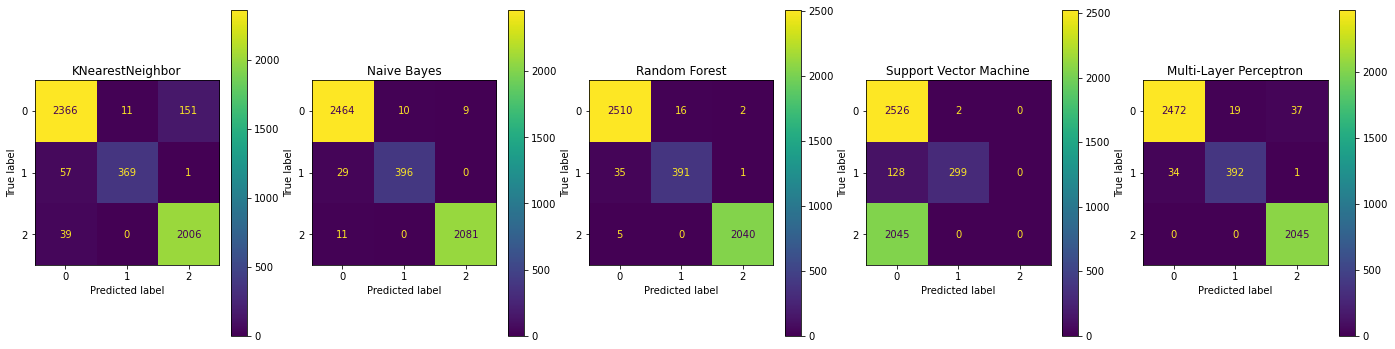

In [26]:
# plot the confusion matrix
fig, axes = plt.subplots(nrows=1, ncols=5,figsize=(24, 6))
plot_confusion_matrix(KNC, X_test, y_test, ax = axes[0])
axes[0].set_title('KNearestNeighbor')
plot_confusion_matrix(NB, X_test_gnb, y_test_gnb, ax = axes[1])
axes[1].set_title('Naive Bayes')
plot_confusion_matrix(RF, X_test, y_test, ax = axes[2])
axes[2].set_title('Random Forest')
plot_confusion_matrix(SVMC, X_test, y_test, ax = axes[3])
axes[3].set_title('Support Vector Machine')
plot_confusion_matrix(MLP, X_test, y_test, ax = axes[4])
axes[4].set_title('Multi-Layer Perceptron')

**Task: Comment on what you see the best classifier is likely to be (1 point).** You can also comment on the misclassification and confusion rates.

The best classiifer is likely the Naive Bayes Classifier, as it has the best scores along the axis, as well as the least confusion. The other classifiers performed pretty as well, expect for Support Vector Machine, which totally failed to corectly predict class 2 which is Stars. SVM predicted all stars as galaxies. KNearestNeighbor has some misclassifications where it predicted some galaxies as stars. 

### 2.4.a K Fold Cross Validation
We will now perform k fold cross valdiation for the classifiers. We use the function ``cross_val_score`` on each ewstimator, on the training set, with 10 folds, and use accuracy as a score metric.

**Task: perform the cross validation over K folds, output the mean and standard deviation of the accuracy (3 points)**

In [27]:
from sklearn.model_selection import cross_val_score

KNC_cross = cross_val_score(KNC, X_train, y_train, scoring = "accuracy", cv = 10)
print("K-nearest neighbors Mean:", KNC_cross.mean(),"Standard Deviation:", KNC_cross.std())

NB_cross = cross_val_score(NB, X_train_gnb, y_train_gnb, scoring = "accuracy", cv = 10)
print("Naive Bayes Mean:", NB_cross.mean(),"Standard Deviation:", NB_cross.std())

RF_cross = cross_val_score(RF, X_train, y_train, scoring = "accuracy", cv = 10)
print("Random Forest Mean:", RF_cross.mean(),"Standard Deviation:", RF_cross.std())

SVMC_cross = cross_val_score(SVMC, X_train, y_train, scoring = "accuracy", cv = 10)
print("Support Vector Machine Mean:", SVMC_cross.mean(),"Standard Deviation:", SVMC_cross.std())

MLP_cross = cross_val_score(MLP, X_train, y_train, scoring = "accuracy", cv = 10)
print("Multi-Layer Perceptron Mean:", MLP_cross.mean(),"Standard Deviation:", MLP_cross.std())

K-nearest neighbors Mean: 0.9176 Standard Deviation: 0.04974977386883281
Naive Bayes Mean: 0.985 Standard Deviation: 0.006826419266350411
Random Forest Mean: 0.9846 Standard Deviation: 0.014506550244630885
Support Vector Machine Mean: 0.5548 Standard Deviation: 0.004489988864128734
Multi-Layer Perceptron Mean: 0.9825999999999999 Standard Deviation: 0.007800000000000007


**Task: Which method won the Xval test (1 point) ?**

see the cell below

<!-- answer here -->

Naive Bayes, with a Mean of 0.985 and Standard Deviation of only 0.0068



### 2.4.c And the winner is ...

Let's compare the results. 
**Task: Create a pandas dataframe with all of the performance metrics, including the results from K-fold cross validation. (2 points)**

In [38]:
# create data frame

results = pd.DataFrame({
    'Model': ['KNN', 'Naive Bayes', 'Random Forest', 'SVC','ANN'],
    'Accuracy': [KNC_acc, NB_acc, RF_acc, SVMC_acc, MLP_acc ],
    'Precision': [KNC_scores[0].mean(), NB_scores[0].mean(), RF_scores[0].mean(), SVMC_scores[0].mean(), MLP_scores[0].mean()],
    'Recall': [KNC_scores[1].mean(), NB_scores[1].mean(), RF_scores[1].mean(), SVMC_scores[1].mean(), MLP_scores[1].mean()],
    'Fscore': [KNC_scores[2].mean(), NB_scores[2].mean(), RF_scores[2].mean(), SVMC_scores[2].mean(), MLP_scores[2].mean()],
    'Kfold_accuracy_mean': [KNC_cross.mean(), NB_cross.mean(), RF_cross.mean(), SVMC_cross.mean(), MLP_cross.mean()],
    'Kfold_accuracy_std': [KNC_cross.std(), NB_cross.std(), RF_cross.std(), SVMC_cross.std(), MLP_cross.std()]})
# sort values by the Fscore with the greatest value first.
results.sort_values('Fscore', ascending = False)
results.head()


,Model,Accuracy,Precision,Recall,Fscore,Kfold_accuracy_mean,Kfold_accuracy_std
0,KNN,0.4432,0.347019,0.346543,0.346666,0.9176,0.049750
1,Naive Bayes,0.4368,0.345928,0.345477,0.345675,0.9850,0.006826
2,Random Forest,0.4400,0.343393,0.343128,0.343172,0.9846,0.014507
3,SVC,0.4676,0.195909,0.334459,0.241424,0.5548,0.004490
4,ANN,0.4390,0.342989,0.342849,0.342899,0.9826,0.007800


**Task: Comment on the accuracy and performance and choose a winner. (1 point)**

see the cell below

<!-- answer here -->
When the precision, recall, and Fscore for each class are averaged out in every model, they are quite similar, except for SVC, which has poor scores despite having the highest accuracy. So, if we are comparing Accuracy and Fscore, the Knearest Neighbor is the winner as it scores best in Accuracy (disrgarding SVC) and Fscore





## 3 Summary (4 points)

### 3.1 Feature Importance using Random Forest Classifier

Decision Trees have the unique property of being able to order features by their ability to split between the classes. If some features dominate over other in the predictive power of classes, one can further reduce the dimension of the features for additional analysis. The vector of feature importance is the module ``rfc.feature_importances_``, sorted with ascending importance. Store the vector of importance .

**Task: plot a bar plot using the function ``matplotlib.pyplot.bar``. (2 points)**

<AxesSubplot:>

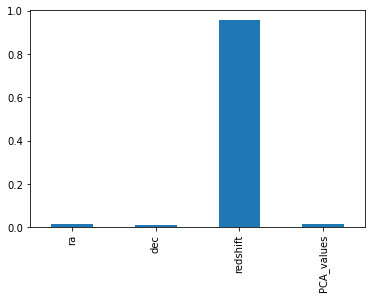

In [37]:
# answer

# vector of importance
importance = RF.feature_importances_

# vector of features
features = ['ra', 'dec', 'redshift', 'PCA_values']
#forest_importances = pd.Series(importance)
#plt.bar(forest_importances, height = 10)
forest_importances = pd.Series(importance, index = features)
forest_importances.plot.bar()

**Task: What are the top three features (1 point)?**

enter in the cell below

<!-- answer -->
Redshift is by far the top feature, with ra and PCA_values being 2 and 3rd but with very low importance relative to Redshift

In this notebook, you have learned that redshift was the best predictor of what object you are observing. Now, did you actualy need to do this all to find this out? Probably not if you were an astrophysicist! But hey, we are not. So great job!

**Task: Briefly comment on what you have learned (1 point)**

see the cell below

<!-- answer -->
Learned that redshift is the best predictor, but also learned a lot about how different classifier's work, how to implement and read confusion matrices, and how to use feature importances.